In [17]:
!pip install -U sagemaker>=2.48

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
import os
import sagemaker
import numpy as np
from sagemaker.tensorflow import TensorFlow

ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"


In [1]:
from sagemaker.debugger import (
    ProfilerConfig,
    FrameworkProfile,
    DetailedProfilingConfig,
    DataloaderProfilingConfig,
    PythonProfilingConfig,
)

In [2]:
sagemaker.__version__

'2.48.2'

In [1]:
!aws s3 cp --recursive s3://feidemo/interdev/archive/Junctions-train/Junctions-train s3://feidemo/interdev/junction-data/train

copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/12479.png to s3://feidemo/interdev/junction-data/train/Priority/12479.png
copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/26004.png to s3://feidemo/interdev/junction-data/train/Priority/26004.png
copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/26008.png to s3://feidemo/interdev/junction-data/train/Priority/26008.png
copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/26009.png to s3://feidemo/interdev/junction-data/train/Priority/26009.png
copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/26013.png to s3://feidemo/interdev/junction-data/train/Priority/26013.png
copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/12481.png to s3://feidemo/interdev/junction-data/train/Priority/12481.png
copy: s3://feidemo/interdev/archive/Junctions-train/Junctions-train/Priority/26024.png to s3:/

In [2]:
!aws s3 cp --recursive s3://feidemo/interdev/archive/Junctions-test/Junctions-test s3://feidemo/interdev/junction-data/test

copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/12494.png to s3://feidemo/interdev/junction-data/test/Priority/12494.png
copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/26014.png to s3://feidemo/interdev/junction-data/test/Priority/26014.png
copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/10025.png to s3://feidemo/interdev/junction-data/test/Priority/10025.png
copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/27002.png to s3://feidemo/interdev/junction-data/test/Priority/27002.png
copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/12499.png to s3://feidemo/interdev/junction-data/test/Priority/12499.png
copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/27079.png to s3://feidemo/interdev/junction-data/test/Priority/27079.png
copy: s3://feidemo/interdev/archive/Junctions-test/Junctions-test/Priority/12497.png to s3://feidemo/interdev/ju

In [6]:
bucket = "feidemo"
key = "interdev/junction-data"                            # Path from the bucket's root to the dataset
trainPath='interdev/archive/Junctions-train/Junctions-train/'
valPath='interdev/archive/Junctions-test/Junctions-test/'

train_instance_type='ml.m5.4xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m5.4xlarge'     # The type of EC2 instance which will be used for deployment

train_input_path = "s3://{}/{}".format(bucket,trainPath)
validation_input_path = "s3://{}/{}".format(bucket, valPath)

'''
we can use the train and validation path as stated above 
or you can 
just rearrange data and use a single path like below
'''
training_data_uri="s3://{}/{}".format(bucket, key)

In [7]:
training_data_uri

's3://feidemo/interdev/junction-data'

In [ ]:
estimator_unfreeze = TensorFlow(
  base_job_name='junctionclass2',
  entry_point="tfModelCode.py",             # Your entry script
  role=role,
  framework_version="2.4.1",               # TensorFlow's version
  py_version="py37",
  instance_count=1,  # "The number of GPUs instances to use"
  instance_type=train_instance_type,
)

print("Training ...")
estimator_unfreeze.fit(training_data_uri)

Training ...
2021-07-13 04:51:17 Starting - Starting the training job...
2021-07-13 04:51:41 Starting - Launching requested ML instancesProfilerReport-1626151877: InProgress
...
2021-07-13 04:52:12 Starting - Preparing the instances for training.........
2021-07-13 04:53:41 Downloading - Downloading input data...
2021-07-13 04:54:04 Training - Downloading the training image..2021-07-13 04:54:20.658606: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-07-13 04:54:20.666551: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-07-13 04:54:20.839299: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-07-13 04:54:24,692 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-07-13 04:54:24,699 sagema

In [ ]:
estimator_unfreeze.deploy(instance_type='ml.m5.2xlarge', initial_instance_count=1)

In [17]:
!pip install tensorflow==2.4.1

  Using cached tensorflow-2.4.1-cp36-cp36m-manylinux2010_x86_64.whl (394.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached grpcio-1.32.0-cp36-cp36m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
     |████████████████████████████████| 147 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 63.0 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 70.4 MB/s eta 0:00:01
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached wrapt-1.12.1-cp36-cp36m-linux_x86_6

In [13]:
from sagemaker.predictor import Predictor
from sagemaker.predictor import json_serializer
predictor=Predictor(endpoint_name='junctionclass2-2021-07-13-10-41-48-571', sagemaker_session=sagemaker_session, serializer=json_serializer)

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import json

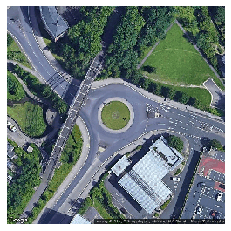

In [15]:
file='Test/Test/Roundabout/R2.png'
img = tf.keras.preprocessing.image.load_img(file, target_size=[250, 250])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.efficientnet.preprocess_input(
    x[tf.newaxis,...])


In [16]:
predictor.predict(x)

The json_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


b'{\n    "predictions": [[0.0110101579, 0.988987863, 1.98785506e-06]\n    ]\n}'

### Using boto3 sagemaker_runtime client

In [17]:
import boto3
client=boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
EndpointName='junctionclass2-2021-07-13-10-41-48-571',
ContentType='application/json',
Body=json.dumps({'instances':x.tolist()}))

In [18]:
json.loads(response['Body'].read().decode("utf-8"))

{'predictions': [[0.0110101579, 0.988987863, 1.98785506e-06]]}

### Attach to a training job that has been left to run 

In [10]:
training_job_name = 'junctionclass2-2021-04-13-22-47-52-645'

In [11]:
tf_estimator = TensorFlow.attach(training_job_name=training_job_name)


2021-04-14 04:48:40 Starting - Preparing the instances for training
2021-04-14 04:48:40 Downloading - Downloading input data
2021-04-14 04:48:40 Training - Training image download completed. Training in progress.
2021-04-14 04:48:40 Uploading - Uploading generated training model
2021-04-14 04:48:40 Completed - Training job completed


### Sagemaker 2 update endpoint steps

import sagemaker

predictor = sagemaker.pytorch.model.PyTorchPredictor(existing_endpoint_name)
predictor.update_endpoint(initial_instance_count=1, instance_type="ml.p3.2xlarge", model_name= new_model_name)

In [19]:
import sagemaker

In [21]:
from sagemaker.workflow.steps import tu